In [153]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [154]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randn
from numpy.random import randint

# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU, SpatialDropout2D, Lambda, Reshape, Conv2DTranspose, Conv2D

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam
from keras import backend


from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict,Counter
from imblearn.over_sampling import SMOTE
from PIL import Image

from kerastuner import HyperModel

<h2>Data Loading and Preparation</h2>

In [155]:
def getSpeciesCode(x):
    part = x.split('_')
    if part[0] == 'ASETRI':
        return 0
    elif part[0] == 'EPTBOT':
        return 1
    elif part[0] == 'MYOEMA':
        return 2
    elif part[0] == 'PIPKUH':
        return 3
    elif part[0] == 'RHIMUS':
        return 4
    elif part[0] == 'RHYNAS':
        return 5
    elif part[0] == 'ROUAEG':
        return 6
    elif part[0] == 'TAPPER':
        return 7
    else:
        return 'Unknown'
    
def getSpecies(x):
    if x == 0:
        return 'A.tridens'
    elif x == 1:
        return 'E.bottae'
    elif x == 2:
        return 'M.emarginatus'
    elif x == 3:
        return 'P.kuhli'
    elif x == 4:
        return 'R.muscatellum'
    elif x == 5:
        return 'R.nasutus'
    elif x == 6:
        return 'R.aegyptius'
    elif x == 7:
        return 'T.perforatus'
    elif x == 8:
        return 'No_Bat'
    else:
        return 'Unknown'
    
    
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted



# # Ytrain in Onehot encoded form 
# def makeOverSamplesSMOTE(X_train,Y_train):
    
#     Y_train_labelled=[]
#     X_dims=X_train.shape

#     for i in range(len(Y_train)):
#         Y_train_labelled.append(np.argmax(Y_train[i]))

#     print('Original trainingset shape %s' %  [(getSpecies(k),v) for k,v in Counter(Y_train_labelled).items()])       
#     X_train= X_train.reshape(-1,X_dims[1]*X_dims[2]*X_dims[3])

#     sm = SMOTE(sampling_strategy='all',k_neighbors=5)
#     X_train, Y_train_labelled = sm.fit_resample(X_train, Y_train_labelled)


#     print('Resampled training set shape %s' % [(getSpecies(k),v) for k,v in Counter(Y_train_labelled).items()])


#     #reshape X_all
#     X_train= X_train.reshape(-1,X_dims[1],X_dims[2],X_dims[3])

#     # update Y_train
#     Y_train= np_utils.to_categorical(Y_train_labelled, num_classes=9)

#     print("After OverSampling\nX_train: shape= ",X_train.shape)
#     print("Y_train: shape= ",Y_train.shape)

    
    
#     return(X_train,Y_train)

In [156]:
image_folder_path = '../data/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]
species = []
for file_name in file_paths:
    sp = file_name.split('_')
    species.append(sp[0])

df = pd.DataFrame(species, columns=['Species'])
df['Species'].value_counts()

RHIMUS    1665
TAPPER     403
PIPKUH     299
RHYNAS     269
EPTBOT     124
ROUAEG     121
MYOEMA     112
ASETRI      25
Name: Species, dtype: int64

In [157]:
X_all = []
Y_all = []

image_folder_path = '../data/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    spectrogram = spectrogram.resize((168, 112))  
    spectrogram = np.array(spectrogram)
    #spectrogram = np.expand_dims(spectrogram, axis=2) 
    X_all.append(spectrogram)
    Y_all.append(getSpeciesCode(file_name))


In [158]:
#Load Noise
image_folder_path = '../data/noise'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    spectrogram = spectrogram.resize((168, 112))  
    spectrogram = np.array(spectrogram)
    #spectrogram = np.expand_dims(spectrogram, axis=2) 
    X_all.append(spectrogram)
    Y_all.append(8)


In [159]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all = (X_all - 127.5) / 127.5

Y_all = np_utils.to_categorical(Y_all, num_classes=9) 


(3426, 112, 168, 3)
(3426,)


In [160]:
# train /test= 80/20% split
# Data is stratified
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state = 245, stratify=Y_all)


In [161]:
y_arr =np.argmax(Y_train, axis=1)
print(y_arr.shape)
unique_elements, counts_elements = np.unique(y_arr, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

(2740,)
Frequency of unique values of the said array:
[[   0    1    2    3    4    5    6    7    8]
 [  20   99   90  239 1332  215   97  322  326]]


<h2> Model Definition and Training </h2>

In [162]:
# custom activation function
def custom_activation(output):
    logexpsum = backend.sum(backend.exp(output), axis=-1, keepdims=True)
    result = logexpsum / (logexpsum + 1.0)
    return result

In [163]:
# define the standalone supervised and unsupervised discriminator models
def define_discriminator(n_classes=9):
    in_image = Input(shape=(112,168,3))
    lay = Convolution2D(filters=56,kernel_size=(7,7),strides=(2,2),padding='same')(in_image)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=72,kernel_size=(5,5),strides=(2,2),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=56,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=72,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Flatten()(lay)

    lay = Dense(48)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)
    lay = Dense(n_classes)(lay)
    # supervised output
    c_out_layer = Activation('softmax')(lay)
    # define and compile supervised discriminator model
    c_model = Model(in_image, c_out_layer)
    c_model.compile(
        loss='sparse_categorical_crossentropy', 
        optimizer=Adam(lr=0.003, beta_1=0.5), 
        metrics=['accuracy'])
 
    
    # unsupervised output
    d_out_layer = Lambda(custom_activation)(lay)
    # define and compile unsupervised discriminator model
    d_model = Model(in_image, d_out_layer)
    d_model.compile(
        loss='binary_crossentropy', 
        optimizer=Adam(lr=0.0002, beta_1=0.5))
    return d_model, c_model

In [164]:
# # create model
# d_model, c_model = define_discriminator()
# # plot the model
# c_model.summary()
# d_model.summary()

In [165]:
# define the standalone generator model
def define_generator(latent_dim):
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 128 * 28 * 42
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((28, 42, 128))(gen)
    # upsample to double -56*84
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # upsample to double- 112*168
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # output
    out_layer = Conv2D(3, (7,7), activation='tanh', padding='same')(gen)
    # define model
    model = Model(in_lat, out_layer)
    return model

In [166]:
# # size of the latent space
# latent_dim = 100

# g_model = define_generator(latent_dim)
# g_model.summary()

In [167]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect image output from generator as input to discriminator
    gan_output = d_model(g_model.output)
    # define gan model as taking noise and outputting a classification
    model = Model(g_model.input, gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model
 

In [168]:
# select a supervised subset of the dataset, ensures classes are balanced
def select_supervised_samples(dataset, n_samples=20, n_classes=9):
    X, y = dataset
    y = np.argmax(y, axis=1)
    X_list, y_list = list(), list()
    n_per_class = int(n_samples / n_classes)
    for i in range(n_classes):
        # get all images for this class
        X_with_class = X[y == i]
        # choose random instances
        ix = randint(0, len(X_with_class), n_per_class)
        # add to list
        [X_list.append(X_with_class[j]) for j in ix]
        [y_list.append(i) for j in ix]
    return asarray(X_list), asarray(y_list)

In [169]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y

In [170]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	z_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = z_input.reshape(n_samples, latent_dim)
	return z_input

In [171]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict(z_input)
	# create class labels
	y = zeros((n_samples, 1))
	return images, y

In [175]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, c_model, latent_dim, dataset, n_samples=20):
#     # prepare fake examples
#     X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
#     # scale from [-1,1] to [0,1]
#     X = (X + 1) / 2.0
#     # plot images
#     for i in range(100):
#         # define subplot
#         pyplot.subplot(10, 10, 1 + i)
#         # turn off axis
#         pyplot.axis('off')
#         # plot raw pixel data
#         pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
#     # save plot to file
#     filename1 = 'generated_plot_%04d.png' % (step+1)
#     pyplot.savefig(filename1)
#     pyplot.close()
    # evaluate the classifier model
    X, y = dataset
    y = np.argmax(y, axis=1)
    _, acc = c_model.evaluate(X, y, verbose=0)
    print('Classifier Accuracy: %.3f%%' % (acc * 100))
    # save the generator model
    filename2 = './models/g_model_%04d.h5' % (step+1)
    g_model.save(filename2)
    # save the classifier model
    filename3 = './models/c_model_%04d.h5' % (step+1)
    c_model.save(filename3)
#     print('>Saved: %s, %s, and %s' % (filename1, filename2, filename3))

In [176]:
# train the generator and discriminator
def train(g_model, d_model, c_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=8, verbose = False):
    # select supervised dataset
    X_sup, y_sup = select_supervised_samples(dataset)
    print(X_sup.shape, y_sup.shape)
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    print('n_epochs=%d, n_batch=%d, 1/2=%d, b/e=%d, steps=%d' % (n_epochs, n_batch, half_batch, bat_per_epo, n_steps))
    # manually enumerate epochs
    for i in range(n_steps):
        # update supervised discriminator (c)
        [Xsup_real, ysup_real], _ = generate_real_samples([X_sup, y_sup], half_batch)
        c_loss, c_acc = c_model.train_on_batch(Xsup_real, ysup_real)
        # update unsupervised discriminator (d)
        [X_real, _], y_real = generate_real_samples(dataset, half_batch)
        d_loss1 = d_model.train_on_batch(X_real, y_real)
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        d_loss2 = d_model.train_on_batch(X_fake, y_fake)
        # update generator (g)
        X_gan, y_gan = generate_latent_points(latent_dim, n_batch), ones((n_batch, 1))
        g_loss = gan_model.train_on_batch(X_gan, y_gan)
        # summarize loss on this batch
        if(verbose):
            print('>%d, c[%.3f,%.0f], d[%.3f,%.3f], g[%.3f]' % (i+1, c_loss, c_acc*100, d_loss1, d_loss2, g_loss))
        # evaluate the model performance every so often
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, c_model, latent_dim, dataset)

In [177]:
# size of the latent space
latent_dim = 100
# create the discriminator models
d_model, c_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = [X_train, Y_train]
# train model
train(g_model, d_model, c_model, gan_model, dataset, latent_dim)

(18, 112, 168, 3) (18,)
n_epochs=20, n_batch=8, 1/2=4, b/e=342, steps=6840
Classifier Accuracy: 18.905%
Classifier Accuracy: 31.606%
Classifier Accuracy: 15.511%
Classifier Accuracy: 26.058%
Classifier Accuracy: 24.635%
Classifier Accuracy: 25.657%
Classifier Accuracy: 20.328%
Classifier Accuracy: 38.321%
Classifier Accuracy: 25.693%
Classifier Accuracy: 24.891%
Classifier Accuracy: 32.810%
Classifier Accuracy: 22.336%
Classifier Accuracy: 31.898%
Classifier Accuracy: 33.102%
Classifier Accuracy: 25.730%
Classifier Accuracy: 26.131%
Classifier Accuracy: 25.073%
Classifier Accuracy: 24.781%
Classifier Accuracy: 26.095%
Classifier Accuracy: 29.635%


## Load and Evaluate

In [201]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

n_classes=9
n_split =1

In [202]:
# load the best model
model = load_model('./models/c_model_6840.h5')

In [192]:
all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()

all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()
all_cm=list()
all_accuracy = list()

all_df = list()

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
             


#generate predictions
y_pred = model.predict(X_test)
actual, predicted = generate_actual_predicted(y_pred, X_test, Y_test)

#calc metrics
curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
curr_macro_prec = precision_score(actual, predicted,average='macro')
curr_macro_rec = recall_score(actual, predicted,average='macro')
curr_macro_f1 = f1_score(actual, predicted,average='macro')

actual_labeled = list()
predict_labeled = list()
for x,y in zip(actual,predicted):
    actual_labeled.append(getSpecies(x))
    predict_labeled.append(getSpecies(y))

labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus','No_Bat']
curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)

curr_fpr = [0] * n_classes
curr_tpr = [0] * n_classes
for i in range(n_classes):
    curr_fpr[i], curr_tpr[i], _ = roc_curve(Y_test[:,i], y_pred[:,i])

curr_prec = [0] * n_classes
curr_rec = [0] * n_classes
for i in range(n_classes):
    curr_prec[i], curr_rec[i], _ = precision_recall_curve(Y_test[:,i], y_pred[:,i])


curr_accuracy = accuracy_score(actual, predicted)

#add to lists
all_base_precision.append(curr_base_prec)
all_base_recall.append(curr_base_rec)
all_macro_precision.append(curr_macro_prec)
all_macro_recall.append(curr_macro_rec)

all_f1.append(curr_f1)
all_macro_f1.append(curr_macro_f1)

all_accuracy.append(curr_accuracy)


all_fpr.append(curr_fpr)
all_tpr.append(curr_tpr)
all_precision.append(curr_prec)
all_recall.append(curr_rec)
all_cm.append(curr_cm)


    
    

In [ ]:
# for df in all_df:
#     _, axs = plt.subplots(ncols=2)

#     sns.lineplot(data=df['loss'],ax=axs[0], label='Training Loss', legend='brief')
#     sns.lineplot(data=df['val_loss'],ax=axs[0], label='Validation Loss', legend='brief')

#     sns.lineplot(data=df['accuracy'],ax=axs[1], label='Training Accuracy', legend='brief')
#     sns.lineplot(data=df['val_accuracy'],ax=axs[1], label='Validation Accuracy', legend='brief')

In [193]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



precision mean by class [0.66666667 0.22222222 0.09459459 0.07291667 0.72222222 0.2919708
 0.17346939 0.34146341 0.95      ]
precision sdev by class [0. 0. 0. 0. 0. 0. 0. 0. 0.]
macro precision mean 0.3928362197423698
macro precision sdev 0.0
recall mean [0.4        0.08       0.31818182 0.23333333 0.15615616 0.74074074
 0.70833333 0.17283951 0.69512195]
recall sdev [0. 0. 0. 0. 0. 0. 0. 0. 0.]
macro recall mean 0.38941187101530367
macro recall sdev 0.0
f1 mean [0.5        0.11764706 0.14583333 0.11111111 0.25679012 0.41884817
 0.27868852 0.2295082  0.8028169 ]
f1 sdev [0. 0. 0. 0. 0. 0. 0. 0. 0.]
macro f1 mean 0.3179159352204397
macro f1 sdev 0.0
accuracy mean 0.2988338192419825
accuracy sdev 0.0


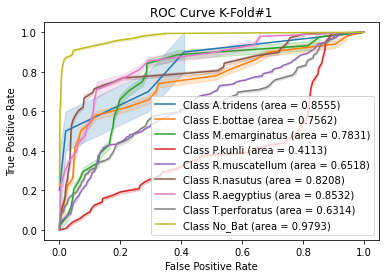

In [195]:
# Plot all K-Fold ROC curves

for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        auc_val = np.around(auc_val,4)
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getSpecies(j) +' (area = ' + str(auc_val) + ')', legend='brief')
        

In [196]:
aucs = list()

for i in range(n_classes):
    aucs.append(list())


# Plot all K-Fold ROC curves

for i in range(n_split):
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        aucs[j].append(auc_val)
        
for i in range(n_classes):
    print("Sp: ", getSpecies(i))
    print("AUC Mean ", np.array(aucs[i]).mean())
    print("Std ", np.array(aucs[i]).std())

Sp:  A.tridens
AUC Mean  0.8555066079295153
Std  0.0
Sp:  E.bottae
AUC Mean  0.7562481089258699
Std  0.0
Sp:  M.emarginatus
AUC Mean  0.7831325301204819
Std  0.0
Sp:  P.kuhli
AUC Mean  0.41134185303514376
Std  0.0
Sp:  R.muscatellum
AUC Mean  0.651830300555513
Std  0.0
Sp:  R.nasutus
AUC Mean  0.8208216127519925
Std  0.0
Sp:  R.aegyptius
AUC Mean  0.8532225579053373
Std  0.0
Sp:  T.perforatus
AUC Mean  0.6314049586776859
Std  0.0
Sp:  No_Bat
AUC Mean  0.9792642545630754
Std  0.0


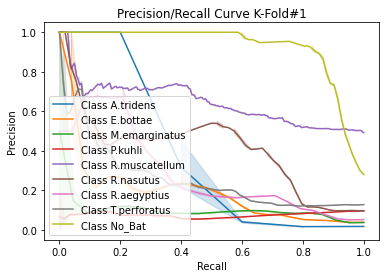

In [197]:
#Plot all K-Fold Precision/Recall curves
for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')

Confusion Matrix K-Fold #1

[[  2   0   0   1   0   1   0   1   0]
 [  0   2   3   1   0  15   2   2   0]
 [  0   1   7   2   4   1   5   2   0]
 [  0   2   5  14   2  29   7   1   0]
 [  1   3  31 145  52  40  44  15   2]
 [  0   1   0   9   0  40   4   0   0]
 [  0   0   1   2   2   0  17   1   1]
 [  0   0  21  17   8  11  10  14   0]
 [  0   0   6   1   4   0   9   5  57]]




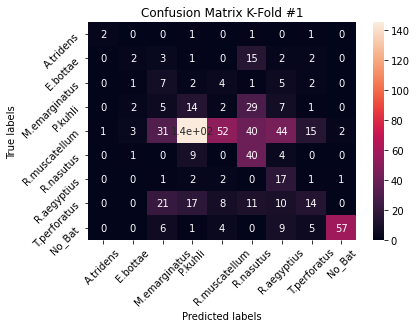

In [198]:
## Plot all K-Fold confusion matrices
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

# Create 1X 5 sub plots
# gs = gridspec.GridSpec(1,n_split)
figs=[]
for i in range(n_split):
    figs.append(plt.figure())
    
for i in range(n_split):
    print('Confusion Matrix K-Fold #'+ str(i+1)+"\n")
    print(all_cm[i])
    print("\n")
    
    ax=figs[i].add_subplot()
    sns.heatmap(all_cm[i], annot=True, ax = ax); #annot=True to annotate cells

    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix K-Fold #'+ str(i+1)); 
    ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

sum of all confuion matrices
 [[  2   0   0   1   0   1   0   1   0]
 [  0   2   3   1   0  15   2   2   0]
 [  0   1   7   2   4   1   5   2   0]
 [  0   2   5  14   2  29   7   1   0]
 [  1   3  31 145  52  40  44  15   2]
 [  0   1   0   9   0  40   4   0   0]
 [  0   0   1   2   2   0  17   1   1]
 [  0   0  21  17   8  11  10  14   0]
 [  0   0   6   1   4   0   9   5  57]]

average of all confuion matrices
 [[  2   0   0   1   0   1   0   1   0]
 [  0   2   3   1   0  15   2   2   0]
 [  0   1   7   2   4   1   5   2   0]
 [  0   2   5  14   2  29   7   1   0]
 [  1   3  31 145  52  40  44  15   2]
 [  0   1   0   9   0  40   4   0   0]
 [  0   0   1   2   2   0  17   1   1]
 [  0   0  21  17   8  11  10  14   0]
 [  0   0   6   1   4   0   9   5  57]]


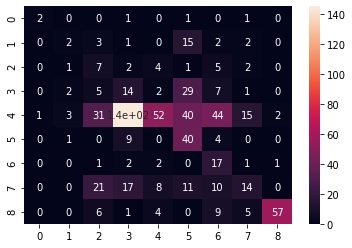

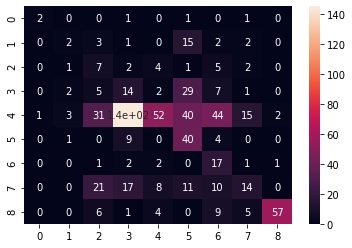

In [199]:
## plot macro cm

sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
for i in range(n_split):
    sum_all_cm+=all_cm[i]
    
    
#plot 
figs=[]
for i in range(2):
    figs.append(plt.figure())
       
print("sum of all confuion matrices\n",sum_all_cm)
ax=figs[0].add_subplot()
sns.heatmap(sum_all_cm, annot=True, ax = ax);

avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
print("\naverage of all confuion matrices\n",avg_all_cm)
ax=figs[1].add_subplot()
sns.heatmap(avg_all_cm, annot=True, ax = ax);

[[0.4  0.   0.   0.2  0.   0.2  0.   0.2  0.  ]
 [0.   0.08 0.12 0.04 0.   0.6  0.08 0.08 0.  ]
 [0.   0.05 0.32 0.09 0.18 0.05 0.23 0.09 0.  ]
 [0.   0.03 0.08 0.23 0.03 0.48 0.12 0.02 0.  ]
 [0.   0.01 0.09 0.44 0.16 0.12 0.13 0.05 0.01]
 [0.   0.02 0.   0.17 0.   0.74 0.07 0.   0.  ]
 [0.   0.   0.04 0.08 0.08 0.   0.71 0.04 0.04]
 [0.   0.   0.26 0.21 0.1  0.14 0.12 0.17 0.  ]
 [0.   0.   0.07 0.01 0.05 0.   0.11 0.06 0.7 ]]


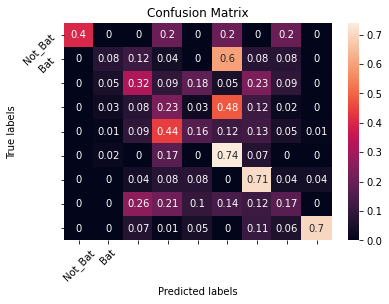

In [200]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cm= sum_all_cm/ sum_all_cm.astype(np.float).sum(axis=1,keepdims = True)
cm = (np.around(cm,2))
print(cm)


labels = ['Not_Bat', 'Bat']


ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);